# Age of Empires IV - Matchmaking System

In [21]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def get_data_path(relative_path: str) -> str:
    """
    Get the absolute path to a file in the `dataset` directory.

    Args:
        relative_path: The path to the file relative to the `dataset` directory including the file name.

    Returns:
        The full path to the file in the `dataset` directory.

    Examples:
        >>> get_data_path("assignment1/boston_listings.csv")
        "C:/Users/username/assignments/dataset/assignment1/boston_listings.csv"
    """
    return os.path.abspath(os.path.join("../dataset", relative_path))

## Exploratory Data Analysis

In [22]:
# Load ranked games data
ranked_games_df = pd.read_json(get_data_path("games_rm_1v1_s8.json"))

# Load leaderboards data
leaderboard_df = pd.read_csv(get_data_path("leadersboards_rm_1v1_elo.csv"))

display(ranked_games_df.head())
display(ranked_games_df.info())

display(leaderboard_df.head())
display(leaderboard_df.info())

,game_id,started_at,finished_at,duration,map_id,map,kind,server,patch,teams
0,137248000,2024-07-18 18:04:10+00:00,2024-07-18 18:34:00+00:00,1790,2129132,Cliffside,rm_1v1,USA (E),11.0.782.0,"[[{'profile_id': 8313452, 'result': 'loss', 'c..."
1,137248046,2024-07-18 18:04:34+00:00,2024-07-18 18:20:34+00:00,960,2064632,The Pit,rm_1v1,UK,11.0.782.0,"[[{'profile_id': 8558578, 'result': 'win', 'ci..."
2,137248062,2024-07-18 18:04:35+00:00,2024-07-18 18:18:31+00:00,836,2141179,Rocky River,rm_1v1,UK,11.0.782.0,"[[{'profile_id': 20006865, 'result': 'win', 'c..."
3,137248220,2024-07-18 18:06:07+00:00,2024-07-18 18:51:37+00:00,2730,2141179,Rocky River,rm_1v1,UK,11.0.782.0,"[[{'profile_id': 7946550, 'result': 'win', 'ci..."
4,137248210,2024-07-18 18:06:05+00:00,2024-07-18 18:30:50+00:00,1485,163361,Dry Arabia,rm_1v1,USA (E),11.0.782.0,"[[{'profile_id': 1610803, 'result': 'loss', 'c..."


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1069766 entries, 0 to 1069765
Data columns (total 10 columns):
 #   Column       Non-Null Count    Dtype              
---  ------       --------------    -----              
 0   game_id      1069766 non-null  int64              
 1   started_at   1069766 non-null  datetime64[ns, UTC]
 2   finished_at  1069766 non-null  datetime64[ns, UTC]
 3   duration     1069766 non-null  int64              
 4   map_id       1069766 non-null  int64              
 5   map          1069766 non-null  object             
 6   kind         1069766 non-null  object             
 7   server       1069766 non-null  object             
 8   patch        1069766 non-null  object             
 9   teams        1069766 non-null  object             
dtypes: datetime64[ns, UTC](2), int64(3), object(5)
memory usage: 81.6+ MB


None

,rank,name,profile_id,rating,games_count,wins_count,last_game_at,rank_level,country
0,1,Fox.Anotand,8432378,2217,1155,749,2024-12-03 20:39:41 UTC,NaN,by
1,2,Beasty,1270139,2193,1737,1487,2024-12-04 18:24:45 UTC,NaN,rs
2,3,El Sensei,5364911,2187,1226,1055,2024-11-29 14:47:54 UTC,NaN,es
3,4,EL.loueMT,8354416,2147,3155,2244,2024-12-04 03:57:44 UTC,NaN,cn
4,5,1puppypaw,8446710,2146,1084,843,2024-12-02 00:56:15 UTC,NaN,ca


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139492 entries, 0 to 139491
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   rank          139492 non-null  int64  
 1   name          139490 non-null  object 
 2   profile_id    139492 non-null  int64  
 3   rating        139492 non-null  int64  
 4   games_count   139492 non-null  int64  
 5   wins_count    139492 non-null  int64  
 6   last_game_at  139492 non-null  object 
 7   rank_level    0 non-null       float64
 8   country       136325 non-null  object 
dtypes: float64(1), int64(5), object(3)
memory usage: 9.6+ MB


None

## Data Preprocessing

In [24]:
# Rank level to elo mapping
rank_levels: dict[str, int] = {
    "Bronze 1": 0,
    "Bronze 2": 400,
    "Bronze 3": 450,
    "Silver 1": 500,
    "Silver 2": 600,
    "Silver 3": 650,
    "Gold 1": 700,
    "Gold 2": 800,
    "Gold 3": 900,
    "Platinum 1": 1000,
    "Platinum 2": 1100,
    "Platinum 3": 1150,
    "Diamond 1": 1200,
    "Diamond 2": 1300,
    "Diamond 3": 1350,
    "Conqueror 1": 1400,
    "Conqueror 2": 1500,
    "Conqueror 3": 1600,
}

# Mapping function to get rank level based on rating
def get_rank_level(rating: int) -> str:
    for rank, threshold in reversed(rank_levels.items()):
        if rating >= threshold:
            return rank
    return "Unranked"

# Assign rank level to each player based on their rating
leaderboard_df["rank_level"] = leaderboard_df["rating"].apply(get_rank_level)

# Calculate win rate for each player
leaderboard_df["win_rate"] = leaderboard_df["wins_count"] / leaderboard_df["games_count"]

display(leaderboard_df.head())

print("Missing values in ranked games data:")
print(ranked_games_df.isnull().sum())

print("\nMissing values in leaderboards data:")
print(leaderboard_df.isnull().sum())

,rank,name,profile_id,rating,games_count,wins_count,last_game_at,rank_level,country,win_rate
0,1,Fox.Anotand,8432378,2217,1155,749,2024-12-03 20:39:41 UTC,Conqueror 3,by,0.648485
1,2,Beasty,1270139,2193,1737,1487,2024-12-04 18:24:45 UTC,Conqueror 3,rs,0.856074
2,3,El Sensei,5364911,2187,1226,1055,2024-11-29 14:47:54 UTC,Conqueror 3,es,0.860522
3,4,EL.loueMT,8354416,2147,3155,2244,2024-12-04 03:57:44 UTC,Conqueror 3,cn,0.711252
4,5,1puppypaw,8446710,2146,1084,843,2024-12-02 00:56:15 UTC,Conqueror 3,ca,0.777675


Missing values in ranked games data:
game_id        0
started_at     0
finished_at    0
duration       0
map_id         0
map            0
kind           0
server         0
patch          0
teams          0
dtype: int64

Missing values in leaderboards data:
rank               0
name               2
profile_id         0
rating             0
games_count        0
wins_count         0
last_game_at       0
rank_level         0
country         3167
win_rate           0
dtype: int64


## Visualizations

### 1. Distribution of Player MMR

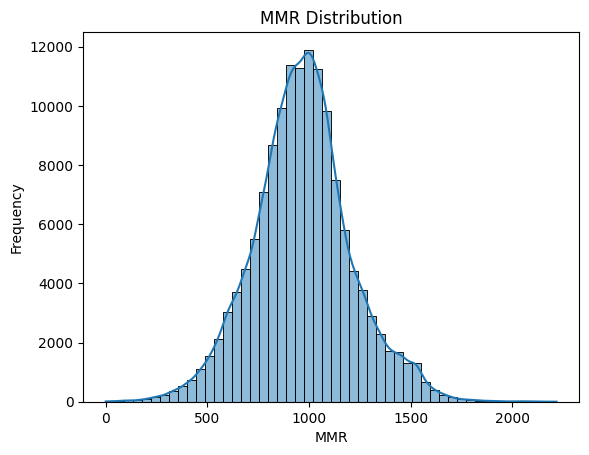

In [33]:
sns.histplot(leaderboard_df["rating"], bins=50, kde=True)
plt.title("MMR Distribution")
plt.xlabel("MMR")
plt.ylabel("Frequency")
plt.show()

### 2. Distribution of Players Across Rank Levels

Number of players in each rank level:


,rank_level,player_count
14,Bronze 1,1502
17,Bronze 2,862
15,Bronze 3,1323
7,Silver 1,4830
9,Silver 2,3845
8,Silver 3,4825
3,Gold 1,13846
2,Gold 2,21604
0,Gold 3,25965
1,Platinum 1,24720


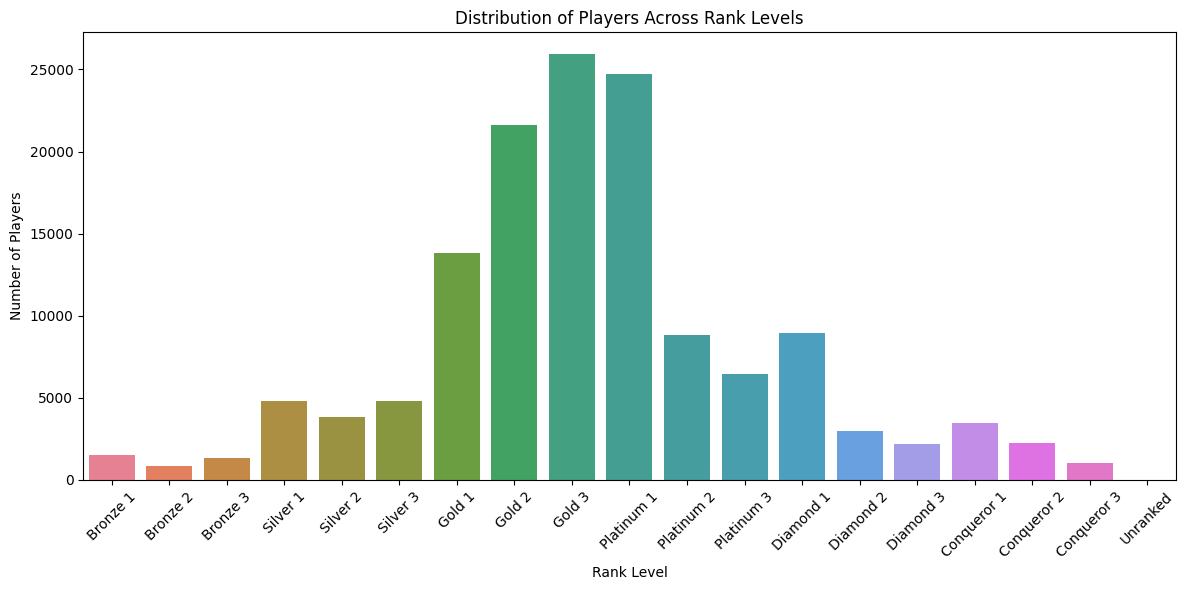

In [42]:
# Count the number of players in each rank level
rank_counts = leaderboard_df["rank_level"].value_counts().reset_index()
rank_counts.columns = ["rank_level", "player_count"]

# Sort the ranks
rank_order = [
    "Bronze 1", "Bronze 2", "Bronze 3",
    "Silver 1", "Silver 2", "Silver 3",
    "Gold 1", "Gold 2", "Gold 3",
    "Platinum 1", "Platinum 2", "Platinum 3",
    "Diamond 1", "Diamond 2", "Diamond 3",
    "Conqueror 1", "Conqueror 2", "Conqueror 3",
    "Unranked"
]

# Ensure all ranks are included in the order
rank_counts["rank_level"] = pd.Categorical(rank_counts["rank_level"], categories=rank_order, ordered=True)
rank_counts.sort_values("rank_level", inplace=True)

print("Number of players in each rank level:")
display(rank_counts)

plt.figure(figsize=(12, 6))
sns.barplot(data=rank_counts, x="rank_level", y="player_count", hue="rank_level", dodge=False)
plt.title("Distribution of Players Across Rank Levels")
plt.xlabel("Rank Level")
plt.ylabel("Number of Players")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 3. Player Win Rates

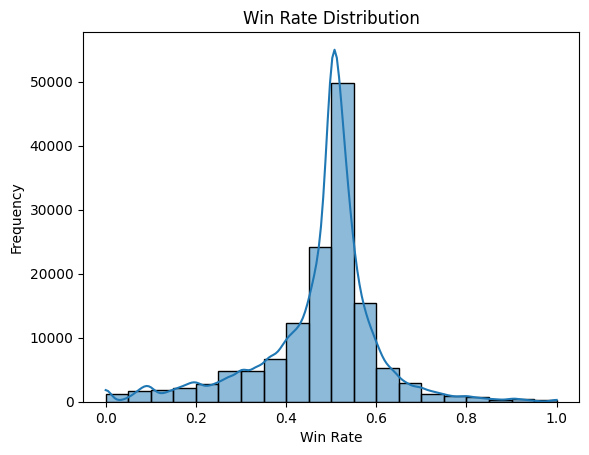

In [26]:
sns.histplot(leaderboard_df["win_rate"], kde=True, bins=20)
plt.title("Win Rate Distribution")
plt.xlabel("Win Rate")
plt.ylabel("Frequency")
plt.show()

#### Average Win Rate by Rank Level

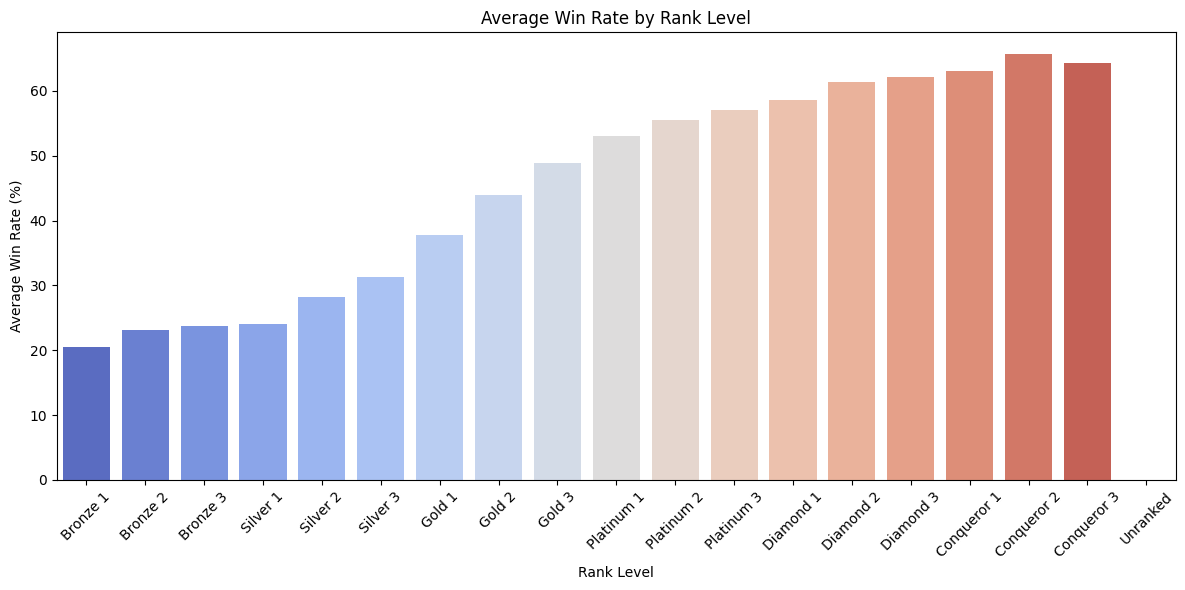

In [45]:
# Calculate average win rate for each rank level
win_rate_by_rank = leaderboard_df.groupby("rank_level")["win_rate"].mean().reset_index()

# Ensure rank levels are ordered
win_rate_by_rank["rank_level"] = pd.Categorical(win_rate_by_rank["rank_level"], categories=rank_order, ordered=True)
win_rate_by_rank.sort_values("rank_level", inplace=True)

# Convert win rate to percentage
win_rate_by_rank["win_rate_percentage"] = win_rate_by_rank["win_rate"] * 100

# Plot the bar chart
plt.figure(figsize=(12, 6))
sns.barplot(data=win_rate_by_rank, x="rank_level", y="win_rate_percentage", hue="rank_level", dodge=False, palette="coolwarm")
plt.title("Average Win Rate by Rank Level")
plt.xlabel("Rank Level")
plt.ylabel("Average Win Rate (%)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### 4. Relationship Between MMR and Games Played

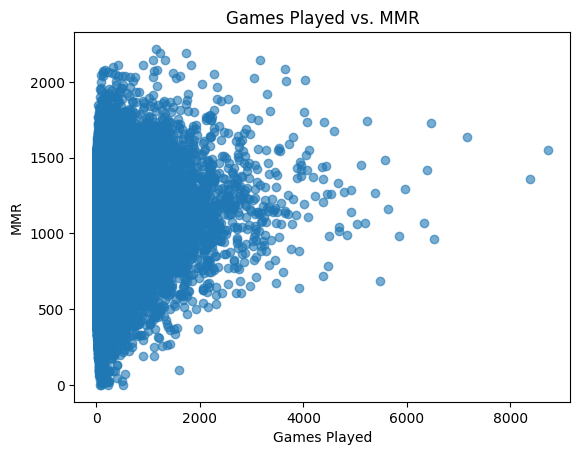

In [27]:
plt.scatter(leaderboard_df["games_count"], leaderboard_df["rating"], alpha=0.6)
plt.title("Games Played vs. MMR")
plt.xlabel("Games Played")
plt.ylabel("MMR")
plt.show()